In [1]:
import cv2
import ipympl
import numpy as np
np.random.seed(42)
import pandas as pd
import math
import scipy.io
import hdf5storage
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
#import matplotlib
#matplotlib.use('nbagg')
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean 
from sklearn.model_selection import train_test_split
from keras.callbacks.callbacks import EarlyStopping
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.python.keras.models import Model
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from keras import backend as K
import tensorflow as tf
import time
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Average
from tensorflow.keras.models import Model
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from sklearn.metrics import classification_report
from keras.callbacks import TensorBoard
#indicate folder to save, plus other options
tensorboard = TensorBoard(log_dir='./logs/run', histogram_freq=0,
    write_graph=True, write_images=False)  

Using TensorFlow backend.


In [2]:
iterations = 10
noise_amount = 2
sparse_g = False
sparsity_g = 1
kernel_g = 0
bias_g = 0
dropout_g = False
dropoutRate_g = 0.1
message = ""

simple = True
contracting = False
sparse = False
sparseDropout = False
denoising = False

if(simple):
    sparse_g = False
    sparsity_g = 1
    kernel_g = 0
    bias_g = 0
    dropout_g = False
    dropoutRate_g = 0.1
    message = "simple model"
elif(contracting):
    sparse_g = False
    sparsity_g = 1
    kernel_g = 0.01
    bias_g = 0.01
    dropout_g = False
    dropoutRate_g = 0.1
    message = "contracting model"
elif(sparse):
    sparse_g = True
    sparsity_g = 1
    kernel_g = 0
    bias_g = 0
    dropout_g = False
    dropoutRate_g = 0.1
    message = "sparse model"
elif(sparseDropout):
    sparse_g = True
    sparsity_g = 1
    kernel_g = 0
    bias_g = 0
    dropout_g = True
    dropoutRate_g = 0.1
    message = "sparseDropout model"
elif(denoising):
    sparse_g = False
    sparsity_g = 1
    kernel_g = 0
    bias_g = 0
    dropout_g = False
    dropoutRate_g = 0.1
    message = "denoising model"
                 

In [3]:
def Average2(lst): 
    return sum(lst) / len(lst) 

In [4]:
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [5]:
def createModel(inputs,table,kernel,bias,sparse,sparsity,dropout,dropoutRate,shape):
    for i in range(len(table)):
        if(i==0):
            if(sparse):
                if(dropout):
                    encoded = Dense(table[i], activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                     )(inputs)
                    encoded = Dropout(dropoutRate)(encoded)
                else:
                    encoded = Dense(table[i], activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                     )(inputs)
            elif(kernel==0):
                encoded = Dense(table[i], activation='relu')(inputs)
            else:
                encoded = Dense(table[i], activation='relu'
                    ,kernel_regularizer=l2(kernel) 
                    ,bias_regularizer=l2(bias)
                    )(inputs)
        elif(i==math.floor(len(table)/2)):
            if(sparse):
                if(dropout):
                    encoded = Dense(table[i], activation='relu'
                    ,activity_regularizer=regularizers.l1(sparsity)
                     )(encoded)
                    encoded = Dropout(dropoutRate)(encoded)
                else:
                    encoded = Dense(table[i], activation='relu'
                    ,activity_regularizer=regularizers.l1(sparsity)
                     )(encoded)
            elif(kernel==0):
                encoded = Dense(table[i], activation='relu')(encoded)
            else:
                encoded = Dense(table[i], activation='relu'
                    ,kernel_regularizer=l2(kernel) 
                    ,bias_regularizer=l2(bias)
                    )(encoded)    
        else:
            if(sparse):
                if(dropout):
                    encoded = Dense(table[i], activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                     )(encoded)
                    encoded = Dropout(dropoutRate)(encoded)
                else:
                    encoded = Dense(table[i], activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                     )(encoded)
            elif(kernel==0):
                encoded = Dense(table[i], activation='relu')(encoded)
            else:
                encoded = Dense(table[i], activation='relu'
                    ,kernel_regularizer=l2(kernel) 
                    ,bias_regularizer=l2(bias)
                )(encoded)
    
    
    if(sparse):
        if(dropout):
            encodedL = Dense(shape, activation='tanh'
            #,activity_regularizer=regularizers.l1(sparsity)
                )(encoded)
            encodedL = Dropout(dropoutRate)(encodedL)
        else:
            encodedL = Dense(shape, activation='tanh'
            #,activity_regularizer=regularizers.l1(sparsity)
                )(encoded)
    elif(kernel==0):
        encodedL = Dense(shape, activation='tanh')(encoded)
    else:
        encodedL = Dense(shape, activation='tanh'
            ,kernel_regularizer=l2(kernel) 
            ,bias_regularizer=l2(bias)
            )(encoded)        
    model = Model(inputs, encodedL)
    model.compile(optimizer='adam', loss='mse')
    #model.summary()
    return model , encodedL
            

In [6]:
file_name = "cardio.mat"
#file_name = "ionosphere.mat"
#file_name = "satellite.mat"
#file_name = "shuttle.mat"
#file_name = "smtp.mat"
#mat = hdf5storage.loadmat('smtp.mat')
#file_name = "wine.mat"
#file_name = "arrhythmia.mat"
#file_name = "thyroid.mat"
mat = scipy.io.loadmat(file_name)
message = "best models "+file_name   
epochs = 200
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=1)]
#callbacks = [EarlyStopping(monitor='val_loss', patience=1),tensorboard]
Xtemp = mat['X']
ytemp = mat['y']
X = np.array(Xtemp)
y = np.array(ytemp)
print(X.shape)
y = y.reshape(X.shape[0],)
print(y.shape)
outliers = 0
clean_data = []
contam_data = []

for i in range(y.shape[0]):
    if(y[i]==1.0):
        outliers+=1;
        contam_data.append(X[i])
    else:
        clean_data.append(X[i])
      

print("Total number of outliers in Dataset")        
print(outliers)
contam = outliers/y.shape[0]
print("Contamination in Dataset")
print(contam)
clean_data = np.array(clean_data)
contam_data = np.array(contam_data)
print(clean_data.shape)
clean_data2 = clean_data.copy()
contam_data2 = contam_data.copy()
# test_data_full = []
# for i in range(176):
#     test_data_full.append(contam_data[i])
# one = np.ones(176)
# test_data_full = np.array(test_data_full)

# test_data_full= np.append(test_data_full,one,1)

# print(test_data_full.shape)

Xy = X.copy()
Xy.shape
Xy = np.array(Xy)
Xy = np.insert(Xy, X.shape[1], y, axis=1)
#print(Xy.shape)
count = outliers
count2 = outliers


    
#selecting all the outliers from dataset
test_data =[]
for i in range(Xy.shape[0]):
    if(Xy[i,X.shape[1]]==1 and count>0):
        test_data.append(Xy[i])
        count = count-1
    
test_data = np.array(test_data)

#selecting random inliers from train data and removing them
indexes = np.random.choice(clean_data.shape[0], outliers, replace=False)

random_clean_data = clean_data[indexes, :]
random_clean_data = np.hstack((random_clean_data, np.zeros((random_clean_data.shape[0], 1), dtype=random_clean_data.dtype)))

indexes = indexes.reshape(outliers,1)

#deleting the values from train data
clean_data = np.delete(clean_data,indexes,0)
#print(clean_data)                
test_data = np.append(test_data,random_clean_data,axis=0)
np.random.shuffle(test_data)

print("test_data.shape")
print(test_data.shape)
#print(test_data.shape)
test_x = test_data[:,:test_data.shape[1]-1]
test_y = test_data[:,test_data.shape[1]-1]
#print(test_x.shape)
#print(test_y.shape)
test_x = pd.DataFrame(test_x)
test_y = pd.DataFrame(test_y)

print("train_data.shape")                    
print(clean_data.shape)    
X_train, X_test = train_test_split(clean_data2,  test_size=0.03, random_state=42)
X_test = np.append(X_test,np.zeros((X_test.shape[0],1),dtype='float64'),axis=1)

inliers_test = X_test.shape[0]

contam_new = contam_data2.shape[0]/X_test.shape[0]
contam_data3 = np.append(contam_data2,np.ones((contam_data2.shape[0],1),dtype='float64'),axis=1)
outliers_test = contam_data3.shape[0]
X_test = np.append(X_test,contam_data3,axis=0)
np.random.shuffle(X_test)
Xy_test = X_test.copy
y_test = X_test[:,X_test.shape[1]-1]
#print(y_test.shape)
X_test = np.delete(X_test,X_test.shape[1]-1,axis=1)
#print(X_test.shape)

X_test_np = X_test
y_test_np = y_test
print(y_test.shape)

X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
print("Number of Outliers in Test")
print(outliers_test)
print("Number of Inliers in Test")
print(inliers_test)
#print(X_train)
#print(X_train.mean())
#print(pd.DataFrame(X_train).describe())
X_train_noisy = X_train
#noisy data
#print(X_train_noisy)
def apply_noise(col):
    #print(col.mean())
    mu, sigma = 0, abs(col.mean())
    noise = np.random.normal(mu, sigma, col.shape[0]) 
    for i  in range(col.shape[0]):
        col[i] += noise_amount*noise[i]

    return col
#print(X_train)
X_train_noisy = np.apply_along_axis(apply_noise, 0, X_train)
scaler = MinMaxScaler(feature_range=(-1, 1))
clean_data = scaler.fit_transform(clean_data)
test_x  = scaler.transform(test_x)
clean_data = pd.DataFrame(clean_data)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)
clean_data = pd.DataFrame(clean_data)


(1831, 21)
(1831,)
Total number of outliers in Dataset
176
Contamination in Dataset
0.0961223375204806
(1655, 21)
test_data.shape
(352, 22)
train_data.shape
(1479, 21)
(226,)
Number of Outliers in Test
176
Number of Inliers in Test
50


In [7]:

for k in range(iterations): 
    tf.keras.backend.clear_session()
    start_time = time.time()
    models = []
    outs = []
    mses = []
    aucs = []
    inputs = Input(shape=(X.shape[1],))
    
#     table = [5000,2000,1000,500,300,200,100,70,40,10,40,70,100,200,300,500,1000,2000,5000]

#     simpleAutoencoder7,simpleAutoencoder_out7 = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
#     models.append(simpleAutoencoder7)
#     outs.append(simpleAutoencoder_out7)
    
#     table = [2000,1000,500,300,200,100,70,40,10,40,70,100,200,300,500,1000,2000]

#     simpleAutoencoder6,simpleAutoencoder_out6 = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
#     models.append(simpleAutoencoder6)
#     outs.append(simpleAutoencoder_out6)
    
#     table = [500,300,200,100,70,40,10,40,70,100,200,300,500]

#     simpleAutoencoder5,simpleAutoencoder_out5 = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
#     models.append(simpleAutoencoder5)
#     outs.append(simpleAutoencoder_out5)
    
#     table = [200,150,100,70,40,10,40,70,100,150,200]

#     simpleAutoencoder,simpleAutoencoder_out = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
#     models.append(simpleAutoencoder)
#     outs.append(simpleAutoencoder_out)
    
#     table = [150,100,70,40,10,40,70,100,150]

#     simpleAutoencoder2,simpleAutoencoder_out2 = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
#     models.append(simpleAutoencoder2)
#     outs.append(simpleAutoencoder_out2)

#     table = [100,70,40,10,40,70,100]

#     simpleAutoencoder3,simpleAutoencoder_out3 = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
#     models.append(simpleAutoencoder3)
#     outs.append(simpleAutoencoder_out3)
    
#     table = [70,40,10,40,70]

#     simpleAutoencoder8,simpleAutoencoder_out8 = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
#     models.append(simpleAutoencoder8)
#     outs.append(simpleAutoencoder_out8)
    
#     table = [40,10,40]

#     simpleAutoencoder4,simpleAutoencoder_out4 = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
#     models.append(simpleAutoencoder4)
#     outs.append(simpleAutoencoder_out4)
    
    
#     #cardio best archs
    
    #simple model
    table = [2000,1000,500,300,200,100,70,40,10,40,70,100,200,300,500,1000,2000]
    simpleAutoencoder1,simpleAutoencoder_out1 = createModel(inputs,table,0,0,False,1,False,0.1,X.shape[1])
    models.append(simpleAutoencoder1)
    outs.append(simpleAutoencoder_out1)
    
    #contracting model
    table = [100,70,40,10,40,70,100]

    simpleAutoencoder3,simpleAutoencoder_out3 = createModel(inputs,table,0.01,0.01,False,1,False,0.1,X.shape[1])
    models.append(simpleAutoencoder3)
    outs.append(simpleAutoencoder_out3)
    
    #sparse model
    simpleAutoencoder2,simpleAutoencoder_out2 = createModel(inputs,table,0,0,True,1,False,0.1,X.shape[1])
    models.append(simpleAutoencoder2)
    outs.append(simpleAutoencoder_out2)
    #sparse dropout model
    table = [2000,1000,500,300,200,100,70,40,10,40,70,100,200,300,500,1000,2000]
    simpleAutoencoder6,simpleAutoencoder_out6 = createModel(inputs,table,0,0,True,1,True,0.1,X.shape[1])
    models.append(simpleAutoencoder6)
    outs.append(simpleAutoencoder_out6)
    #denoising model
    table = [5000,2000,1000,500,300,200,100,70,40,10,40,70,100,200,300,500,1000,2000,5000]

    simpleAutoencoder7,simpleAutoencoder_out7 = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
    models.append(simpleAutoencoder7)
    outs.append(simpleAutoencoder_out7)
    
    
#     #ion best archs
    
#     #simple model
#     table = [100,70,40,10,40,70,100]
#     simpleAutoencoder1,simpleAutoencoder_out1 = createModel(inputs,table,0,0,False,1,False,0.1,X.shape[1])
#     models.append(simpleAutoencoder1)
#     outs.append(simpleAutoencoder_out1)
    
#     #contracting model
#     table = [200,100,70,40,10,40,70,100,200]

#     simpleAutoencoder3,simpleAutoencoder_out3 = createModel(inputs,table,0.01,0.01,False,1,False,0.1,X.shape[1])
#     models.append(simpleAutoencoder3)
#     outs.append(simpleAutoencoder_out3)
    
#     #sparse model
#     table = [100,70,40,10,40,70,100]
    
#     simpleAutoencoder2,simpleAutoencoder_out2 = createModel(inputs,table,0,0,True,1,False,0.1,X.shape[1])
#     models.append(simpleAutoencoder2)
#     outs.append(simpleAutoencoder_out2)
#     #sparse dropout model
    
#     simpleAutoencoder6,simpleAutoencoder_out6 = createModel(inputs,table,0,0,True,1,True,0.1,X.shape[1])
#     models.append(simpleAutoencoder6)
#     outs.append(simpleAutoencoder_out6)
#     #denoising model
#     table = [200,100,70,40,10,40,70,100,200]

#     simpleAutoencoder7,simpleAutoencoder_out7 = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
#     models.append(simpleAutoencoder7)
#     outs.append(simpleAutoencoder_out7)
    
    
#      #sat best archs
    
#     #simple model
#     table = [2000,1000,500,300,200,100,70,40,10,40,70,100,200,300,500,1000,2000]
#     simpleAutoencoder1,simpleAutoencoder_out1 = createModel(inputs,table,0,0,False,1,False,0.1,X.shape[1])
#     models.append(simpleAutoencoder1)
#     outs.append(simpleAutoencoder_out1)
    
#     #contracting model
    

#     simpleAutoencoder3,simpleAutoencoder_out3 = createModel(inputs,table,0.01,0.01,False,1,False,0.1,X.shape[1])
#     models.append(simpleAutoencoder3)
#     outs.append(simpleAutoencoder_out3)
    
#     #sparse model
    
    
#     simpleAutoencoder2,simpleAutoencoder_out2 = createModel(inputs,table,0,0,True,1,False,0.1,X.shape[1])
#     models.append(simpleAutoencoder2)
#     outs.append(simpleAutoencoder_out2)
#     #sparse dropout model
    
#     simpleAutoencoder6,simpleAutoencoder_out6 = createModel(inputs,table,0,0,True,1,True,0.1,X.shape[1])
#     models.append(simpleAutoencoder6)
#     outs.append(simpleAutoencoder_out6)
#     #denoising model
    

#     simpleAutoencoder7,simpleAutoencoder_out7 = createModel(inputs,table,0,0,False,1,False,0.1,X.shape[1])
#     models.append(simpleAutoencoder7)
#     outs.append(simpleAutoencoder_out7)
    
    

#     for i in range(len(models)):
#         if(denoising):
#             models[i].fit(X_train_noisy, X_train,
#                             epochs=epochs,
#                             batch_size=256,
#                             shuffle=True,
#                             callbacks=callbacks,
#                             validation_split=0.4,
#                             verbose=0
#                            )
#             decoded = models[i].predict(X_test)
#             mse = np.mean(np.power(X_test - decoded, 2), axis=1)
#             mse = mse.reshape(-1, 1)
#             scaler = MinMaxScaler(feature_range=(0, 1))
#             mse = scaler.fit_transform(mse)
#             mses.append(mse)
#         else:
#             models[i].fit(X_train, X_train,
#                             epochs=epochs,
#                             batch_size=256,
#                             shuffle=True,
#                             callbacks=callbacks,
#                             validation_split=0.4,
#                             verbose=0
#                            )
#             decoded = models[i].predict(X_test)
#             mse = np.mean(np.power(X_test - decoded, 2), axis=1)
#             mse = mse.reshape(-1, 1)
#             scaler = MinMaxScaler(feature_range=(0, 1))
#             mse = scaler.fit_transform(mse)
#             mses.append(mse)
            
            
    for i in range(len(models)):
        if(i<(len(models)-1)):
            models[i].fit(X_train, X_train,
                            epochs=epochs,
                            batch_size=256,
                            shuffle=True,
                            callbacks=callbacks,
                            validation_split=0.4,
                            verbose=0
                           )
            decoded = models[i].predict(X_test)
            mse = np.mean(np.power(X_test - decoded, 2), axis=1)
            mse = mse.reshape(-1, 1)
            scaler = MinMaxScaler(feature_range=(0, 1))
            mse = scaler.fit_transform(mse)
            mses.append(mse)
        else:
            models[i].fit(X_train_noisy, X_train,
                            epochs=epochs,
                            batch_size=256,
                            shuffle=True,
                            callbacks=callbacks,
                            validation_split=0.4,
                            verbose=0
                           )
            decoded = models[i].predict(X_test)
            mse = np.mean(np.power(X_test - decoded, 2), axis=1)
            mse = mse.reshape(-1, 1)
            scaler = MinMaxScaler(feature_range=(0, 1))
            mse = scaler.fit_transform(mse)
            mses.append(mse)
        
    
    temp = np.array(mses)
    ensemble = (np.sum(temp,axis = 0)/(len(mses)))
    #print(ensemble)
    mses.append(ensemble)
    
    
  
    #x = concatenate([decoded3_de2, decoded3_s3,decoded3,decoded3_s2])  # merge the outputs of the two models
    x = Average()(outs) 

    out = Dense(X.shape[1],activation='tanh'
                #, kernel_regularizer=l2(kernel_reg) 
                #, bias_regularizer=l2(bias_reg)
               )(x)  # final layer of the network
    Emodel = Model(inputs=inputs, outputs=out)
    for l in Emodel.layers:
        l.trainable = False

    Emodel.layers[len(Emodel.layers)-1].trainable = True

    Emodel.compile(optimizer='adam', loss='mse')
    Emodel.fit(X_train, X_train,
                    epochs=500,
                    batch_size=256,
                    shuffle=True,
                    callbacks=callbacks,
                    validation_split=0.4,
                    verbose=0
    )

    ensemble_pred = Emodel.predict(X_test)
    #print(ensemble_pred)
    ensemble2_mse = np.mean(np.power(X_test - ensemble_pred, 2), axis=1)
    ensemble2_mse = ensemble2_mse.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    ensemble2_mse = scaler.fit_transform(ensemble2_mse)
    #print(ensemble2_mse)
    mses.append(ensemble2_mse)
    
    for i in range(len(mses)):
        
        fpr_keras3, tpr_keras3, thresholds_keras3 = roc_curve(y_test, mses[i])
        auc_keras3 = auc(fpr_keras3, tpr_keras3)
        aucs.append(auc_keras3)
        #plt.figure(1)
        #plt.plot([0, 1], [0, 1], 'k--')

        #plt.plot(fpr_keras3, tpr_keras3, label='Keras (area = {:.3f})'.format(auc_keras3))
        print(auc_keras3)
    #plt.xlabel('False positive rate')
    #plt.ylabel('True positive rate')
    #plt.title('ROC curve')
    #plt.legend(loc='best')
    #plt.show()    
    
    print('results')
    
    #3% tha thewrw lathos apo ta swsta -> predict apo ta training dedomena gia na vgei to threshold
    votes = [];
    threshes = [];
    for i in range(len(mses)):
        threshes.append(Find_Optimal_Cutoff(y_test,mses[i]))
    for i in range(len(threshes)):
        temp = mses[i]
        tempvotes = []
        for j in range(len(y_test)):
            if(temp[j]>threshes[i]):
                tempvotes.append(1)
            else:
                tempvotes.append(0)
        votes.append(tempvotes)
    y_test_list = y_test.values.tolist()

    results_with_thresh = []
    for j in range(len(threshes)):    
        sumss = 0;
        for i in range(len(y_test_list)):
            if(votes[j][i]==y_test_list[i][0]):
                sumss = sumss+1
        #print(str(vote_result[i])+'\t '+ str(y_test_list[i]))  
        results_with_thresh.append(sumss/len(y_test_list));
        print(sumss/len(y_test_list))
    
    vote_result = []
    for i in range(len(y_test_list)):
        if((votes[0][i]+votes[1][i]+votes[2][i]+votes[3][i]+votes[4][i])/5>=0.5):
            vote_result.append(1)
        else:
            vote_result.append(0)

    sumss = 0;
    for i in range(len(y_test_list)):
        if(vote_result[i]==y_test_list[i][0]):
            sumss = sumss+1
        #print(str(vote_result[i])+'\t '+ str(y_test_list[i]))        
    results_with_thresh.append(sumss/len(y_test_list))
    print(sumss/len(y_test_list))

    if(k==0):
        sums = aucs;
        sums_votes = results_with_thresh
    else:
        temp = aucs
        temp2 = results_with_thresh
        for tempi in range(0,len(sums)):
            sums[tempi] = sums[tempi]+temp[tempi];
        for tempi2 in range(0,len(results_with_thresh)):
            sums_votes[tempi2] = sums_votes[tempi2]+temp2[tempi2]
            
            
    import csv
    from datetime import date
    with open('resultsGeneral.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        if(k==iterations-1):
            today = date.today()
            d1 = today.strftime("%d/%m/%Y")
            writer.writerow([d1])
            writer.writerow([file_name])
            writer.writerow([message])
            writer.writerow(["params","noise_amount",noise_amount,"iterations" ,iterations])
            writer.writerow(["Simple","Contracting","Sparse","Sparse Dropout","Denoising","Ensemble","Ensemble2"])
            #writer.writerow(["Model 8L","Model 7L","Model 6L","Model 5L","Model 4L","Model 3L","Model 2L","Model 1L","Ensemble","Ensemble2"])
            writer.writerow([x/iterations for x in sums])
            writer.writerow(['thresholds']);
            writer.writerow(threshes);
            writer.writerow(['results']);
            writer.writerow(["Simple","Contracting","Sparse","Sparse Dropout","Denoising","Ensemble","Ensemble2","Voting"])
            writer.writerow([x/iterations for x in sums_votes]);
    print(k)
    print("--- %s seconds ---" % (time.time() - start_time))

0.9704545454545455
0.9760227272727272
0.9780681818181818
0.9767045454545454
0.97625
0.9773863636363636
0.9747727272727272
results
0.9026548672566371
0.911504424778761
0.915929203539823
0.911504424778761
0.8938053097345132
0.9203539823008849
0.9070796460176991
0.911504424778761
0
--- 32.902000188827515 seconds ---
0.9737500000000001
0.9756818181818181
0.9744318181818182
0.9794318181818181
0.9736363636363636
0.9781818181818183
0.9744318181818181
results
0.8982300884955752
0.911504424778761
0.9070796460176991
0.9292035398230089
0.8893805309734514
0.911504424778761
0.911504424778761
0.9070796460176991
1
--- 28.40099787712097 seconds ---
0.9815909090909091
0.97625
0.9743181818181819
0.9820454545454544
0.9667045454545454
0.9798863636363636
0.9746590909090909
results
0.915929203539823
0.915929203539823
0.911504424778761
0.9292035398230089
0.8805309734513275
0.915929203539823
0.911504424778761
0.911504424778761
2
--- 28.210001945495605 seconds ---
0.93125
0.975340909090909
0.9746590909090909
0

In [8]:
print(Find_Optimal_Cutoff(y_test,mses[4]))

[0.1968456033416146]


0.9829545454545454
0.9761363636363636
0.974090909090909
0.9788636363636363
0.9738636363636364
0.9788636363636364
0.9751136363636363


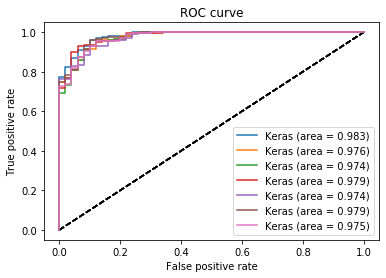

In [9]:
for i in range(len(mses)):
        
        fpr_keras3, tpr_keras3, thresholds_keras3 = roc_curve(y_test, mses[i])
        auc_keras3 = auc(fpr_keras3, tpr_keras3)
        #aucs.append(auc_keras3)
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')

        plt.plot(fpr_keras3, tpr_keras3, label='Keras (area = {:.3f})'.format(auc_keras3))
        print(auc_keras3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()    

In [10]:
votes = [];
threshes = [];
#pd.set_option("display.max_rows", None, "display.max_columns", None)
#print(y_test)
for i in range(len(mses)):
    threshes.append(Find_Optimal_Cutoff(y_test,mses[i]))
#print(mses[0])
for i in range(len(threshes)):
    temp = mses[i]
    tempvotes = []
    for j in range(len(y_test)):
        if(temp[j]>threshes[i]):
            tempvotes.append(1)
        else:
            tempvotes.append(0)
    votes.append(tempvotes)
votes = np.array(votes)
#print([pd.DataFrame(votes[0]),y_test])
#print(pd.concat([pd.DataFrame(votes[0]), y_test], axis=1))


y_test_list = y_test.values.tolist()
for j in range(len(threshes)):    
    sumss = 0;
    for i in range(len(y_test_list)):
        if(votes[j][i]==y_test_list[i][0]):
            sumss = sumss+1
        #print(str(vote_result[i])+'\t '+ str(y_test_list[i]))  
    print(j)
    print(sumss/len(y_test_list))


0
0.915929203539823
1
0.911504424778761
2
0.911504424778761
3
0.9292035398230089
4
0.8938053097345132
5
0.911504424778761
6
0.9070796460176991


In [11]:
vote_result = []
for i in range(len(y_test_list)):
    if((votes[0][i]+
        #votes[1][i]+
        #votes[2][i]+
        #votes[3][i]+
        votes[4][i]+
        #votes[5][i]+
        votes[6][i]
        )/3>=0.5):
        vote_result.append(1)
    else:
        vote_result.append(0)

sumss = 0;
for i in range(len(y_test_list)):
    if(vote_result[i]==y_test_list[i][0]):
        sumss = sumss+1
    #print(str(vote_result[i])+'\t '+ str(y_test_list[i]))        
print(sumss/len(y_test_list))

0.9026548672566371
